<a href="https://colab.research.google.com/github/RiseAboveAll/Global_Wheat_Detection/blob/master/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

Images to Download from : https://drive.google.com/drive/folders/1nuiuUfCOp2X_FTr28-63sOOx4q_iF0EX?usp=sharing

**Problem Statement**


Open up your pantry and you’re likely to find several wheat products. Indeed, your morning toast or cereal may rely upon this common grain. Its popularity as a food and crop makes wheat widely studied. To get large and accurate data about wheat fields worldwide, plant scientists use image detection of "wheat heads"—spikes atop the plant containing grain. These images are used to estimate the density and size of wheat heads in different varieties. Farmers can use the data to assess health and maturity when making management decisions in their fields.

However, accurate wheat head detection in outdoor field images can be visually challenging. There is often overlap of dense wheat plants, and the wind can blur the photographs. Both make it difficult to identify single heads. Additionally, appearances vary due to maturity, color, genotype, and head orientation. Finally, because wheat is grown worldwide, different varieties, planting densities, patterns, and field conditions must be considered. Models developed for wheat phenotyping need to generalize between different growing environments. Current detection methods involve one- and two-stage detectors (Yolo-V3 and Faster-RCNN), but even when trained with a large dataset, a bias to the training region remains.

The Global Wheat Head Dataset is led by nine research institutes from seven countries: the University of Tokyo, Institut national de recherche pour l’agriculture, l’alimentation et l’environnement, Arvalis, ETHZ, University of Saskatchewan, University of Queensland, Nanjing Agricultural University, and Rothamsted Research. These institutions are joined by many in their pursuit of accurate wheat head detection, including the Global Institute for Food Security, DigitAg, Kubota, and Hiphen.

In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

Wheat is a staple across the globe, which is why this competition must account for different growing conditions. Models developed for wheat phenotyping need to be able to generalize between environments. If successful, researchers can accurately estimate the density and size of wheat heads in different varieties. With improved detection farmers can better assess their crops, ultimately bringing cereal, toast, and other favorite dishes to your table.

In [ ]:
labels = pd.read_csv('/content/drive/My Drive/Global Wheat Detection/Global Wheat Detection/train.csv/train.csv')
labels.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In the raw data each bounding box is in an array of length 4 but formatted as a string. The below block of code groups the bounding boxes by image id and places the bounding boxes as numpy arrays next to each image id. The image id can then be used to quickly retrieve all of the bounding boxes.

In [ ]:
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

labels = labels.groupby('image_id').apply(group_boxes)

In [ ]:
labels

image_id
00333207f    [[0.0, 654.0, 37.0, 111.0], [0.0, 817.0, 135.0...
005b0d8bb    [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
006a994f7    [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
00764ad5d    [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
00b5fefed    [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
                                   ...                        
ffb445410    [[0.0, 534.0, 54.0, 118.0], [0.0, 480.0, 38.0,...
ffbf75e5b    [[0.0, 697.0, 21.0, 58.0], [104.0, 750.0, 77.0...
ffbfe7cc0    [[256.0, 0.0, 64.0, 99.0], [390.0, 0.0, 48.0, ...
ffc870198    [[447.0, 976.0, 78.0, 48.0], [18.0, 141.0, 218...
ffdf83e42    [[306.0, 178.0, 67.0, 88.0], [367.0, 167.0, 63...
Length: 3373, dtype: object

Here's a sample of five bounding boxes for one of the images

In [ ]:
labels['00333207f'].shape

(55, 4)

With the labels extracted from the data, now we need the images loaded as numpy arrays. At this point it is worth splitting the data into a training and validation set. 

In [ ]:
train_image_ids = np.unique(labels.index.values)[0:3363]
val_image_ids = np.unique(labels.index.values)[3363:3373]

With the ids split it's now time to load the images. To keep the training of the model relatively fast I will resize each image from (1024,1024) to (256,256). 

In [ ]:
def load_image(path,image_id):
    image = Image.open(path + image_id + ".jpg")
    image = image.resize((256, 256))
    
    return np.asarray(image)

Define path variable 

```

path = '/content/drive/My Drive/Global Wheat Detection/Global Wheat Detection/train/'

```

In [ ]:
path ='/content/drive/My Drive/Global Wheat Detection/Global Wheat Detection/train/'


In [ ]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(path,image_id)
    train_labels[image_id] = labels[image_id].copy() / 4

In [ ]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(path,image_id)    
    val_labels[image_id] = labels[image_id].copy() / 4

## Visualise images

Before going on it is worth having a look at some of the images and bounding boxes in the dataset. For that a few helper functions will be required. The below functions take an image id and the corresponding bounding boxes and return the bounding boxes drawn onto the image.

In [ ]:
Path ='/content/drive/My Drive/Global Wheat Detection/Global Wheat Detection/'

def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open(Path + source +'/' + image_id + ".jpg")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

In [ ]:
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

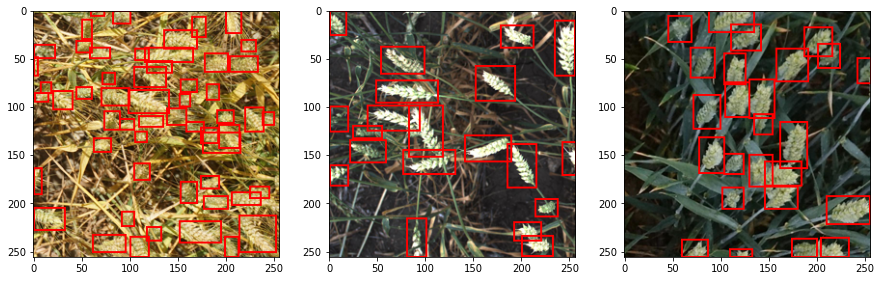

In [ ]:
show_images(train_image_ids[0:3], train_labels)

## Clean bounding boxes

There are a small number of bounding boxes in this dataset that do not bound a head of wheat. While the number is small enough that the model can still learn how to detect the heads of wheat they still cause a little bit of inaccuracy. Below I'll search for tiny bounding boxes that cannot possibly fit a head of wheat inside them and huge bounding boxes that miss the head of wheat they are aimed at.

In [ ]:
tiny_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] <= 10 and label[2] * label[3] != 0:
            tiny_bboxes.append(i)

            
print(str(len(tiny_bboxes)) + ' tiny bounding boxes found')

50 tiny bounding boxes found


In [ ]:
huge_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] > 8000:
            huge_bboxes.append(i)

            
print(str(len(huge_bboxes)) + ' huge bounding boxes found')

13 huge bounding boxes found


The tiny bounding boxes are actually too small to show when visualised on an image. However we can take a peak at one of the huge bounding boxes.

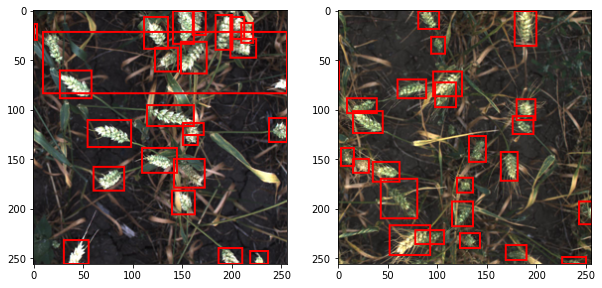

In [ ]:
show_images(train_image_ids[562:564], train_labels)

I did some more manual inspection of the bad labels picked out of this code that I have not included in this notebook. I found that some huge bounding boxes were actually okay as they bound a very zoomed in image. To this end I have listed a few to be kept (1079, 1371, 2020). Otherwise the below code throws out any bounding boxes whose area is larger than 8000 or smaller than 5.

In [ ]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):

            # remove huge bbox
            if label[2] * label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue

            # remove tiny bbox
            elif label[2] < 5 or label[3] < 5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
                
    return good_labels

train_labels = clean_labels(train_image_ids, train_labels)

## Data pipeline

Usually I would use Tensorflows data api or keras data generators to build a pipeline to get data into the model. However the pre-processing that needs to be done for this model is not trivial and it turned out to be easier to create a custom data generator. This takes the form of a class that is passed to keras' fit generator function. It contains the following functionality:

- define the size of the dataset. Keras needs this to work out how long an epoch is.
- shuffle the dataset.
- get an image and augment it to add variety to the dataset. This includes amending bounding boxes when a head of wheat has changed in the image.
- reshape the bounding boxes to a label grid.

I'll start by initialising the class.

In [ ]:
i=0
for j in range(1,16):
  i+=16
print(i)

240


In [ ]:
image_grid = np.zeros((16, 16, 4))
cell = [0, 0, 256 / 16, 256 / 16]
for i in range(0, 16):
  for j in range(0, 16):
    image_grid[i,j] = cell
    cell[0] = cell[0] + cell[2]
  cell[0] = 0
  cell[1] = cell[1] + cell[3]


In [ ]:
image_grid

array([[[  0.,   0.,  16.,  16.],
        [ 16.,   0.,  16.,  16.],
        [ 32.,   0.,  16.,  16.],
        ...,
        [208.,   0.,  16.,  16.],
        [224.,   0.,  16.,  16.],
        [240.,   0.,  16.,  16.]],

       [[  0.,  16.,  16.,  16.],
        [ 16.,  16.,  16.,  16.],
        [ 32.,  16.,  16.,  16.],
        ...,
        [208.,  16.,  16.,  16.],
        [224.,  16.,  16.,  16.],
        [240.,  16.,  16.,  16.]],

       [[  0.,  32.,  16.,  16.],
        [ 16.,  32.,  16.,  16.],
        [ 32.,  32.,  16.,  16.],
        ...,
        [208.,  32.,  16.,  16.],
        [224.,  32.,  16.,  16.],
        [240.,  32.,  16.,  16.]],

       ...,

       [[  0., 208.,  16.,  16.],
        [ 16., 208.,  16.,  16.],
        [ 32., 208.,  16.,  16.],
        ...,
        [208., 208.,  16.,  16.],
        [224., 208.,  16.,  16.],
        [240., 208.,  16.,  16.]],

       [[  0., 224.,  16.,  16.],
        [ 16., 224.,  16.,  16.],
        [ 32., 224.,  16.,  16.],
        .

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((16, 16, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 16, 256 / 16] 

        for i in range(0, 16):
            for j in range(0, 16):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

Next I will add some methods to the class that keras needs to operate the data generation. length is used to determine how many images there are in the dataset. on_epoch_end is called at the end of each epoch (as well once before training starts) to get the index of all images in the dataset. It is also has the opportunity to shuffle the dataset per epoch if the generator was configured to do so.

In [ ]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

Regarding the augmentations a number of transformations will be applied to each training image before they are fed into the model. This helps to add some diversity to a small dataset effectively growing it to a much larger one:

- **random sized crop:** The model needs to be able to detect a wheat head regardless of how close or far away the head is to the camera. To produce more zoom levels in the dataset the crop method will take a portion of the image and zoom in to create a new image with larger wheat heads.
- **flip amd rotate**: The wheat heads can point in any direction. To create more examples of wheat heads pointing in different directions the image will randomly be flipped both horizontally and vertically or rotated.
- **hue saturation and brightness:** these are various methods that will alter the lighting of the image which will help to create different lighting scenarios. This helps as the test pictures are from various countries each with their own lighting levels.
- **noise:** Some wheat heads aren't quite in focus. Adding some noise to the images helps to catch these wheat heads while also forcing the model to learn more abstract wheat head shapes. This helps a lot with over-fitting.
- **cutout**: randomly remove small squares of pixels in the image. This prevents the model simply memorizing certain wheat heads and instead forces it to learn the patterns that represent a wheat head.
- **clahe:** this is a must have. In many images the wheat heads are a similar colour to the grass in the background making it tricky for the model to differentiate between them. CLAHE helps to exemplify the colour difference between the two.
- **grey scale:** I found that there were a few images with a yellow/gold tint. My model was learning to detect wheat heads without a tint (as most images do not contain a tint) and was really struggling to detect anything on the yellow images. By converting all images to grey scale the model is forced to ignore these tints making it much more effective at identifying wheat heads regardless of tint.

I also greyscale and apply CLAHE to each validation image as the model has learnt on grey images where the wheat heads are given a lighter shade of grey.

In [ ]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise()
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
             
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

The next finctions load an image and the corresponding bounding boxes depending on randomly picked image ids. As well as loading the images the above augmentations are added to an image as it is loaded. As the albumentaitons library was used the apply these augmentations I get the bounding boxes re-sized for free.

In [ ]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

The final part of the data generator class re-shapes the bounding box labels. It's worth mentioning here that there are a number of ways to represent a bounding box with four numbers. Some common ways are coco (the shape the boxes are in the raw data), voc-pascal and yolo.



I'll be using the yolo shape for this model. In addition to the above shape, yolo detects objects by placing a grid over the image and asking if an object (such as a wheat head) is present in any of the cells of the grid. I've decided to use a 16x16 grid for this challenge which I'll refer to as a label grid. The bounding boxes are reshaped to be offset within the relevant cells of the image. Then all four variables (x, y, width and height) are scaled down to a 0-1 scale using the width and height of the image.


It's x and y are offset to the cell while width and height remain the same*

Any cells in the grid that have no objects within them contain a bounding box with the dimensions [0, 0, 0, 0].

Each bounding box gets a confidence score where a value of 1 tells us that an object (wheat head) is present in the cell and a value of 0 tells us that no object is present. So a cell with an object present could contain a value like this: [1, 0.5, 0.5, 0.2, 0.2] telling us that there is an object present (due to the confidence score of 1, the centre of the bounding box is exactly in the middle of the cell and the box is 20% of the images total width and height.

As a cell could contain two overlapping heads of wheat I have configured the grid to contain up to two bounding boxes. These are known as anchor boxes.

The below code takes the list of bounding boxes for an image and puts them into the yolo label grid shape.

In [ ]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((16, 16, 10))

    for i in range(0, 16):
        for j in range(0, 16):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            if anchor_one[0] != 0 and anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            if anchor_one[0] != 0 and anchor_two[0] != 0:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [ ]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=8, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

## Model

With the data ready to go I'll define and train the model. As mentioned before this model is heavily inspired by yolo, specifically yolo v3. This is a large and at times complex model. Below is an outline of the model. Basically the model begins with a convolutional layer with 32 filters which doubles in size in the next layer. The filters are then halved in size before doubling every layer up to 128 layers. The filters are then halved again while a larger stride reduces the size of the input image. This pattern of doubling and halving filter sizes continues with a few repeated blocks until we reach a size of 1024. A few resnet skip layers are added in as well to stabilise the large number of layers and reduce the chance of vanishing gradients.

 An outline of the model taken from the yolov3 [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf).*

Below is my keras implementation of the model. The model is mostly in line with the yolov3 architecture. The main difference is a greater number of max pooling layers and a few layers added on the end to reduce the output shape the desired shape (i.e. a label grid).

In [ ]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

One issue with yolo is that it is likely to contain more cells in its label grid that contain no objects than cells that do contain objects. It is easy then for the model to focus too much on learning to reduce no object cells to zero and not focus enough on getting the bounding boxes to the right shape. To overcome this the yolo [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf) suggests weighting the cells containing bounding boxes five times higher and the cells with no bounding boxes by half. 

I have defined a custom loss function to do just this. I have also split the loss function into three parts. The first takes care of the confidence score that is trying to work out if a label grid cell contains a head of wheat or not. Binary cross entropy is used here as that is a binary classification task. The second part looks at the x,y position of the bounding boxes while the third looks at the width,height of the bounding boxes. MSE (mean squared loss) is used for the second and third parts as they are regression tasks. 

In [ ]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

I experimented with a few optimisers including like SGD but in the end Adam was the fastest and most reliable function. I have kept the learning rate reasonably high as it can take a number of steps to get the model moving quickly towards convergence. A higher rate helps to reduce the number of steps needed to get the model going.

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

While a high learning rate at the beginning of a training run is great at the start, it can cause issues as the model approaches convergence when smaller, more careful steps are needed. I considered using learning rate decay to handle this but decided on a callback to reduce the learning rate when it plateaus (or increases) over the space of two epochs. This allows the model to make the most of a higher rate until it that rate is too high at which point the model wuicky reduces it.

In addition to this I have added an early stopping callback to stop the model training if is no longer able to reduce the loss. This reduces any waste processing and provides faster feedback if the model just isn't training very well.

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

Finally the model is ready to be trained. The data generators are passed into the fit generator method of the model alongside the callbacks and the maximum number of epochs to take. Be warned that with 100 or less images this model can train at an okay speed on CPU. Any more images than that will need the GPU (which could still run for a few hours).

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
420/420 [==============================] - 368s 875ms/step - loss: 0.4787 - val_loss: 0.4461
Epoch 2/15
420/420 [==============================] - 372s 885ms/step - loss: 0.3521 - val_loss: 0.4056
Epoch 3/15
420/420 [==============================] - 371s 884ms/step - loss: 0.3134 - val_loss: 0.3337
Epoch 4/15
210/420 [==============>...............] - ETA: 3:04 - loss: 0.2944

In [ ]:
model.save_weights('wheat_detection_model.h5')

## Prediction post processing

The model outputs the predicted bounding boxes as a label grid. However to visualise the bounding boxes on an image or submit them to the competition the shape for one images bounding boxes need changing from (16,16,10) to (m, 4) where m represents the number of bounding boxes that have a high confidence.

This first function transforms the boxes from the yolo format to the coco format. It does this through the following:

- return the scale of the boxes from 0-1 to 0-256
- change the x,y from the centre of the box to the top left corner
- change width and height to x_max, y_max i.e. change to voc shape

In [ ]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 16)
    im_height = (image_grid[:,:,3] * 16)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

Next the bounding boxes with low confidence need removing. I also need to remove any boxes that overlap another box. Luckily Tensorflow has a non-max suppression function that filters out both low confidence boxes and removes one box if any two overlap.

In [ ]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((16*16, 4))
    second_anchors = predictions[:,:,6:10].reshape((16*16, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

Wrap these post-processing functions into one and output the predicted bounding boxes as a dictionary where the image id is the key.

In [ ]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

Let's see how the model did by producing predictions for the training and validation datasets and show these boxes on the first four images from each set.

In [ ]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=1, 
    shuffle=False,
    augment=False
)

train_predictions = model.predict(train_generator)
train_predictions = process_predictions(train_predictions, train_image_ids, image_grid)

In [ ]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

In [ ]:
show_images(train_image_ids[0:4], train_predictions)

In [ ]:
show_images(val_image_ids[0:4], val_predictions)

## Evaluate Model

With the model trained it's time to look at the quality of the model. Begin by plotting the loss curve.

In [ ]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

Then visualise the first few layers of the model to see how each layer influences the bounding boxes. Start by copying the model and configuring the new one to return each layers output when a prediction is made.

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
evaluation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

Then pick an image and cycle through the layers making a prediction and visualising the features outputted by the layer. The warm colours represent where the features lie in this image.

In [ ]:
image = Image.open(path + train_image_ids[1] + ".jpg")
image = image.resize((256, 256))

pixels = np.asarray(image) / 255
pixels = np.expand_dims(pixels, axis=0)

In [ ]:
num_of_layers = len(layer_outputs)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))

layer = 0
for i in range(0, 2):
    for j in range(0, 6):
        layer_output = evaluation_model.predict(pixels)[layer]
        axes[i, j].imshow(layer_output[0, :, :, 1], cmap='inferno')
        
        layer = layer + 1